In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'digit-recognizer:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3004%2F861823%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240213%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240213T085648Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da0b03bbdb9784aed145cd1c3e03b11e5b64efe4a398a29030a1efdb5ae3d92d106ebd0484abb031459e81ea556c3f1105be153b5084260378d0455f423631530ae02dc35c9ebc25cdd85907d4830c161ead8daa69b24ab410614affec738a42c07a55a4a00afad17f43b1133a994e6a058c29626b785deca79e7d587443c7e62c14bd82186f237e9e4ca2b03c48b3748d6e59c049aee2d338213649e27065509c905c2cce143f78d5dbe57d3f129d19f059c8ce52275071d733b6ef789e13f3f0667e22357f640bd094fc93fd6444b58711568e0940baa856c888c36d22621c40572a3707cde60442a6a14b318ea9d34ffd44dc4d80fb0e96329745f64a1bd2d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 16054568 bytes downloaded
Downloaded and uncompressed: digit-recognizer
Data source import complete.


In [7]:
#Libraries for deep learning
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=c157865aedcf76267a3e88713d5c43b68e9bf95cda699773fcfcef9c5fad6243
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


# **Numerical Digit Recognition using CNN**

Hi Kaggle Fellows,
This is my first try on Deep Learning model. Many more to come. I hope this will help all the beginners and I'm waiting to here from you all. Thanking you all in advance for the feedbacks and suggestions.

## **STEP 1: Importing Required Libraries**

In [2]:
#Libraries for data preprocessing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')


np.random.seed(2)

"np.random.seed(2)" sets the seed of the NumPy random number generator to 2.
The NumPy random number generator is a pseudorandom number generator that produces a sequence of numbers that appears random but is actually determined by an initial seed value. Setting the seed to a specific value ensures that the same sequence of random numbers is generated every time the code is run, which can be useful for debugging and testing purposes.

In [3]:
#Libraries for data splitting and confusion matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import itertools

The itertools module is a standard library module in Python that provides various functions for creating iterators and generators for efficient looping. It contains a collection of tools that allow you to work with sequences, iterators, and functions that return iterators.

In [10]:
#Libraries for deep learning
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

1. "from tensorflow.keras.utils import to_categorical" - Import a function from Keras to convert numerical labels to one-hot encoded categorical labels.
2. "from keras.models import Sequential" - Import the Sequential model from Keras for building a linear stack of layers.
3. "from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D" - Import various layer types from Keras for constructing a neural network architecture.
4. "from keras.optimizers import RMSprop" - Import the RMSprop optimizer from Keras for training a neural network.
5. "from keras.preprocessing.image import ImageDataGenerator" - Import the ImageDataGenerator class from Keras for generating batches of image data with data augmentation.
6. "from keras.callbacks import ReduceLROnPlateau" - Import the ReduceLROnPlateau callback from Keras for reducing the learning rate during training when the validation loss plateaus.

## **STEP 2: Data Preprocessing**

In [11]:
#Loading the dataset
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

In [12]:
#Viewing the dataset
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#Defining the features and output for training data
X_train = train.drop(labels = ["label"],axis = 1)
y_train = train["label"]

In [14]:
#Checking for null values
#Training data
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [15]:
#Test data
test.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

There are no null values

In [16]:
#Normalization
X_train = X_train / 255.0
test = test / 255.0

Done the above step because, CNN converg faster on [0....1] data than on [0....255]. Also, performed a grayscale normalization to reduce the effect of illumination's differences.

In [17]:
#Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Note: Train and test images (28px x 28px) are as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices. But Keras requires an extra dimension in the end which correspond to RGB channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we should reshape 784px vectors to 28x28x3 3D matrices.

In [18]:
#Label Encoding
#Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

In [19]:
#Splitting the trainng dataset as for training and the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=0)

"stratify = True" ensures that the distribution of the target variable is approximately the same in both the training and test datasets.

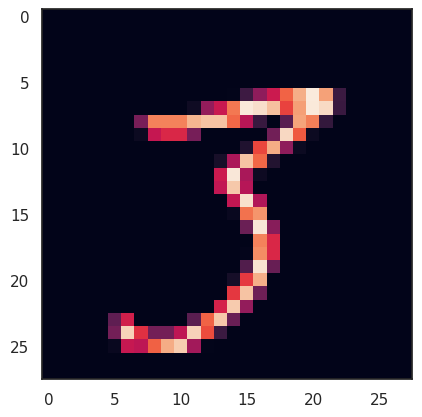

In [20]:
#Visualizing an example for better understanding the images in our dataset
g = plt.imshow(X_train[8][:,:,0])

## **STEP 3: CNN - Convolution Neural Networks**

In [21]:
#Setting the CNN model
#CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

The Convolutional Neural Network (CNN) model using the Keras API with the following architecture:

1. Input layer: a 2D convolutional layer with 32 filters, a kernel size of (5, 5), and a ReLU activation function. The input shape is (28, 28, 1), representing a grayscale image with dimensions 28x28 pixels.
2. Hidden layer 1: a 2D convolutional layer with 32 filters, a kernel size of (5, 5), and a ReLU activation function. Padding is set to 'Same' to ensure the output size matches the input size.
3. Max pooling layer 1: a 2D max pooling layer with a pool size of (2, 2) and a stride of (2, 2). This layer reduces the spatial dimensions of the output from the previous layer by a factor of 2, helping to reduce overfitting.
4. Dropout layer 1: a dropout layer with a rate of 0.25, which randomly drops out 25% of the input units during training to further prevent overfitting.
5. Hidden layer 2: a 2D convolutional layer with 64 filters, a kernel size of (3, 3), and a ReLU activation function.
6. Hidden layer 3: a 2D convolutional layer with 64 filters, a kernel size of (3, 3), and a ReLU activation function. Padding is set to 'Same' to ensure the output size matches the input size.
7. Max pooling layer 2: a 2D max pooling layer with a pool size of (2, 2) and a stride of (2, 2). This layer reduces the spatial dimensions of the output from the previous layer by a factor of 2.
8. Dropout layer 2: a dropout layer with a rate of 0.25.
9. Flatten layer: a layer that flattens the output from the previous layer into a 1D array.
10. Fully connected layer: a fully connected layer with 256 units and a ReLU activation function.
11. Dropout layer 3: a dropout layer with a rate of 0.5.
12. Output layer: a fully connected layer with 10 units and a softmax activation function, which outputs a probability distribution over the 10 classes (digits 0-9).

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

In [25]:
#Setting the Optimizer
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

The optimizer is responsible for adjusting the weights and biases of the network during training in order to minimize the error or loss function. The annealer, on the other hand, is responsible for adjusting the learning rate of the optimizer during training. The learning rate determines the size of the steps taken by the optimizer when updating the weights and biases of the network. A high learning rate can cause the optimizer to overshoot the minimum of the loss function, while a low learning rate can cause the optimizer to take too long to converge to the minimum.

In [26]:
#Compiling the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

To train our neural network model, we must set up a score function, a loss function, and an optimization algorithm. The loss function measures the discrepancy between the predicted and true labels for labeled images, and for categorical classifications with more than two classes, we use the "categorical_crossentropy" form of the loss function.
The optimizer is a crucial component of the training process, as it iteratively updates the parameters of the model (e.g. filters, kernel values, weights, and biases of neurons) to minimize the loss function. For this particular model, we have selected RMSprop as our optimizer, with default values. RMSprop is an effective optimizer that adjusts the Adagrad method in a simple way to reduce its aggressive, monotonically decreasing learning rate. Alternatively, we could have used Stochastic Gradient Descent ('sgd') optimizer, but it is slower than RMSprop.

In [27]:
#Setting the Annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

To improve the speed and accuracy of the optimizer in finding the global minimum of the loss function, an annealing method of the learning rate (LR) was used.
The LR determines the step size that the optimizer takes while traversing the 'loss landscape'. A higher LR results in larger steps and faster convergence, but poor sampling and a higher likelihood of falling into a local minima.
To efficiently reach the global minimum of the loss function, it is better to have a decreasing LR during training. However, to maintain fast computation time with a high LR, the LR was decreased dynamically every X steps (epochs) only if necessary, i.e., when accuracy did not improve.
The Keras.callbacks ReduceLROnPlateau function was used to reduce the LR by half if the accuracy did not improve after 3 epochs.

In [38]:
epochs = 30
batch_size = 86

The model will train for 1 epoch with a batch size of 86. To achieve a higher accuracy of 0.9967, the number of epochs can be increased to 30.

In [ ]:
#Fitting the model to the training set
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), verbose = 2)

Epoch 1/30
440/440 - 133s - loss: 0.0210 - accuracy: 0.9942 - val_loss: 0.0201 - val_accuracy: 0.9938 - 133s/epoch - 302ms/step
Epoch 2/30
440/440 - 133s - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0339 - val_accuracy: 0.9943 - 133s/epoch - 302ms/step
Epoch 3/30
440/440 - 131s - loss: 0.0182 - accuracy: 0.9944 - val_loss: 0.0273 - val_accuracy: 0.9940 - 131s/epoch - 298ms/step
Epoch 4/30


## **STEP 4: Evaluation**

132/132 [==============================] - 4s 31ms/step


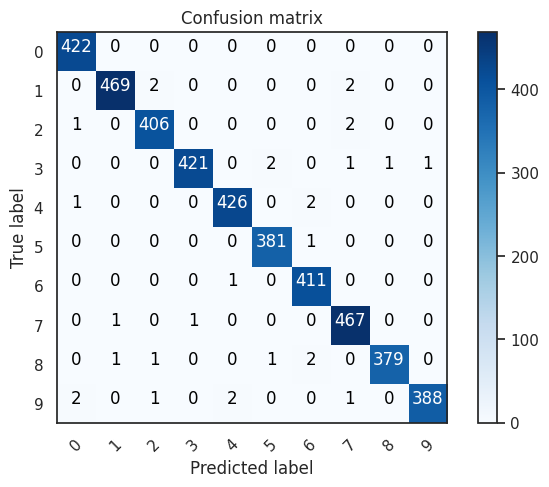

In [34]:
#CONFUSION MATRIX

#Defining a function for confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Predicting the values from the validation dataset
y_pred = model.predict(X_val)
#Converting predictions classes to one hot vectors
y_pred_classes = np.argmax(y_pred,axis = 1)
#Converting validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1)
#Computing the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
#Plotting the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

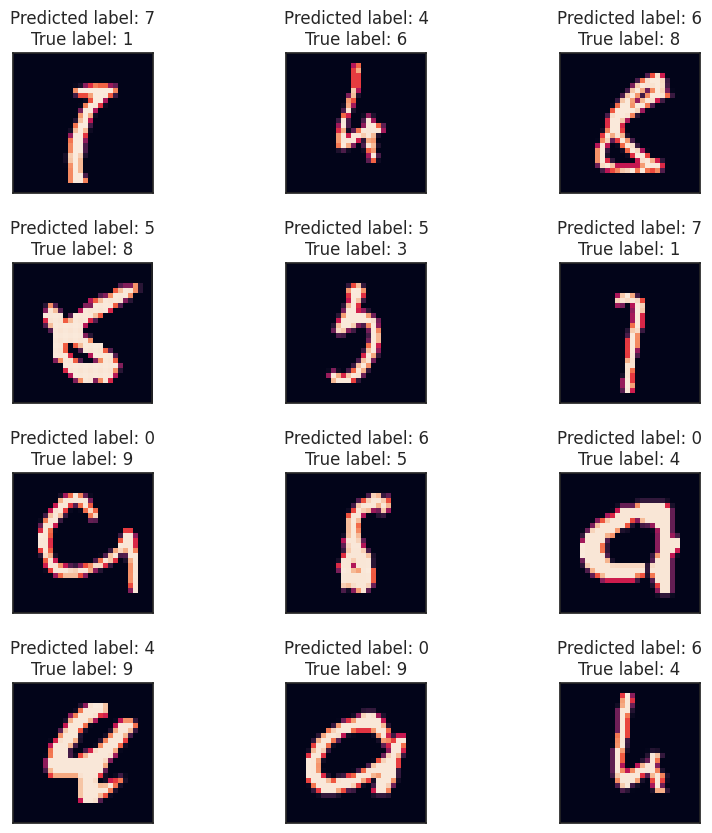

In [35]:
#To display some error results

errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

#Defining a function for plotting the erros results
def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    """ This function shows 12 images with their predicted and real labels"""
    nrows = 4
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, figsize=(10, 10))
    fig.subplots_adjust(hspace=0.5)
    for i, axi in enumerate(ax.flat):
        if i < len(errors_index):
            error = errors_index[i]
            axi.imshow((img_errors[error]).reshape((28,28)))
            axi.set_title("Predicted label: {}\nTrue label: {}".format(pred_errors[error], obs_errors[error]))
        axi.set_xticks([])
        axi.set_yticks([])

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors, axis=1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_delta_errors = np.argsort(delta_pred_true_errors)

# Top 12 errors
most_important_errors = sorted_delta_errors[-12:]

# Displaying the top 12 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

In [36]:
# predicting the results
results = model.predict(test)

# selecting the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")
results

875/875 [==============================] - 33s 37ms/step


0        2
1        0
2        9
3        9
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [37]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv("submission.csv",index=False)